In [1]:
!pip install pyarrow

import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
import os

SAMPLE_SIZE = 10000

%matplotlib inline
import matplotlib.pyplot as plt
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
class Dataset:
    def __init__(self, file:str):
        self.file_name : str = file
        self.types : dict = self.load_types()
        self.df : pd.DataFrame = None
        
    def name(self):
        return re.search(r'\/([\w\d]*)\.csv',self.file_name).group(1)
    
    def types_file(self):
        return 'kaggle/working/'+ self.name() +'.npy'
        
    def save_types(self):
        np.save(self.types_file(), self.types)
        
    def load_types(self):
        if os.path.isfile(self.types_file()):
            self.types = np.load(self.types_file(),allow_pickle='TRUE').item()
            return self.types
        return None
    

datasets = [
    Dataset(file='../input/instagram-dataset/instagram_profiles.csv'), 
    Dataset(file='../input/instagram-dataset/instagram_locations.csv'), 
    Dataset(file='../input/instagram-dataset/instagram_posts.csv')
]
profiles, locations, posts = datasets

In [3]:
profiles.types = {
#     'sid' : int,
    'profile_id' : int,
    'profile_name' : pd.StringDtype(storage='pyarrow'),
    'firstname_lastname' : pd.StringDtype(storage='pyarrow'),
    'description' : pd.StringDtype(storage='pyarrow'),
    'following' : int,
    'followers' : int,
    'n_posts' : int,
    'url' : pd.StringDtype(storage='pyarrow'),
#     'cts' : pd.DatetimeTZDtype(tz='UTC'), #obtained through parse_dates=['cts']
    'is_business_account' : pd.BooleanDtype()
}
posts.types = {
#     'sid' : int, # gives an error, maybe because it's the index?
    'sid_profile' : int,
    'post_id' : pd.StringDtype(storage='pyarrow'),
    'profile_id' : int,
    'location_id' : int,
    'description' : pd.StringDtype(storage='pyarrow'),
    'post_type' : pd.CategoricalDtype(categories=[1,2,3]),
    'numbr_likes' : int,
    'number_comments' : int
}
locations.types = {
#     'sid' : int, # gives an error, maybe because it's the index?
    'id' : int,
    'name' : pd.StringDtype(storage='pyarrow'),
    'street' : pd.StringDtype(storage='pyarrow'),
    'zip' : pd.StringDtype(storage='pyarrow'),
    'city' : pd.StringDtype(storage='pyarrow'),
    'region' : pd.StringDtype(storage='pyarrow'),
    'cd' : pd.CategoricalDtype(),
    'phone' : pd.StringDtype(storage='pyarrow'),
    'aj_exact_city_match' : pd.BooleanDtype(),
    'aj_exact_country_match' : pd.BooleanDtype(),
    'blurb' : pd.StringDtype(storage='pyarrow'),
    'dir_city_id' : pd.StringDtype(storage='pyarrow'),
    'dir_city_name' : pd.StringDtype(storage='pyarrow'),
    'dir_city_slug' : pd.StringDtype(storage='pyarrow'),
    'dir_country_id' : pd.CategoricalDtype(),
    'dir_country_name' : pd.CategoricalDtype(),
    'lat' : pd.Float32Dtype(),
    'lng' : pd.Float32Dtype(),
    'primary_alias_on_fb' : pd.StringDtype(storage='pyarrow'),
    'slug' : pd.StringDtype(storage='pyarrow'),
    'website' : pd.StringDtype(storage='pyarrow'),
}

In [4]:
def get_types(signed=True, unsigned=True, custom=[]):
    '''Returns a pandas dataframe containing the boundaries of each integer dtype'''
    # based on https://stackoverflow.com/a/57894540/9419492
    pd_types = custom
    if signed:
        pd_types += [pd.Int8Dtype() ,pd.Int16Dtype() ,pd.Int32Dtype(), pd.Int64Dtype()]
    if unsigned:
        pd_types += [pd.UInt8Dtype() ,pd.UInt16Dtype(), pd.UInt32Dtype(), pd.UInt64Dtype()]
    type_df = pd.DataFrame(data=pd_types, columns=['pd_type'])
    type_df['np_type'] = type_df['pd_type'].apply(lambda t: t.numpy_dtype)
    type_df['min_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).min)
    type_df['max_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).max)
    type_df['allow_negatives'] = type_df['min_value'] < 0
    type_df['size'] = type_df['np_type'].apply(lambda row: row.itemsize)
    type_df.sort_values(by=['size', 'allow_negatives'], inplace=True)
    return type_df.reset_index(drop=True)
    
get_types()

def downcast_int(file_path, column:str, chunksize=10000, delimiter=',', signed=True, unsigned=True):
    '''Assigns the smallest possible dtype to an integer column of a csv'''
    types = get_types(signed, unsigned)
    negatives = False
    for chunk in pd.read_csv(file_path, usecols=[column],delimiter=delimiter,skiprows=lambda x:x%100==0,chunksize=chunksize):
        M = chunk[column].max()
        m = chunk[column].min()
        if not signed and not negatives and m < 0 :
            types = types[types['allow_negatives']] # removes unsigned rows
            negatives = True
        if m < types['min_value'].iloc[0]:
            types = types[types['min_value'] < m]
        if M > types['max_value'].iloc[0]:
            types = types[types['max_value'] > M]
        if len(types) == 1:
            print('early stop')
            break
    return types['pd_type'].iloc[0]

def optimize_cols(file, int_cols, delimiter=',', signed=True, unsigned=True):
    out = dict()
    for col in int_cols:
        out[col] = downcast_int(file, col, delimiter=delimiter, signed=signed, unsigned=unsigned)
    return out

In [5]:
for ds in datasets:
    if not ds.load_types():
        int_cols = [k for k,v in ds.types.items() if v is int]
        print(int_cols)
        ds.types.update(optimize_cols(ds.file_name, int_cols, delimiter='\t'))
        print(f'Optimized {len(int_cols)} types for {ds.name()}')
#     ds.types.update({k:pd.StringDtype(storage='pyarrow') for k,v in ds.types.items() if v==pd.StringDtype(storage='pyarrow')})
    ds.save_types()
#     print(ds.types)

for ds in datasets:
    ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'], nrows=SAMPLE_SIZE)
    avg_mem_unoptimized = pd.read_csv(ds.file_name, index_col='sid', delimiter='\t', nrows=SAMPLE_SIZE).memory_usage(deep=True).sum()/SAMPLE_SIZE
    avg_mem_optimized = ds.df.memory_usage(deep=True).sum()/SAMPLE_SIZE
    print(f'{ds.name().ljust(19)} mean optimized memory usage per entry:  {round(avg_mem_optimized):3} B vs {round(avg_mem_unoptimized):4} B  : {round(avg_mem_optimized/avg_mem_unoptimized*100,2):5}%') 

instagram_profiles  mean optimized memory usage per entry:  150 B vs  542 B  : 27.71%
instagram_locations mean optimized memory usage per entry:  272 B vs 1117 B  : 24.34%
instagram_posts     mean optimized memory usage per entry:  277 B vs  752 B  : 36.89%


## RISPOSTE DOMANDE

In [ ]:
# importing locations dataset (309.6 mb)
# df_loc = pd.read_csv('instagram_locations.csv', sep='\t')

In [ ]:
# importing posts dataset (12.88 gb)
# df_posts = pd.read_csv('instagram_posts.csv', sep='\t', )

In [3]:
# importing profiles dataset (698.8 mb)
# df_prof = pd.read_csv('instagram_profiles.csv', sep='\t')

In [4]:
# RQ2_1 = df_prof[["profile_id", "n_posts"]].copy()

In [5]:
# RQ2_1.head()

,profile_id,n_posts
0,4.721050e+09,170.0
1,5.905830e+08,2878.0
2,1.074147e+09,431.0
3,1.472039e+09,NaN
4,3.531421e+09,NaN


In [6]:
# RQ2_1.dropna(inplace=True)

In [6]:
# RQ2_1.head()

,profile_id,n_posts
0,4.721050e+09,170.0
1,5.905830e+08,2878.0
2,1.074147e+09,431.0
5,1.450642e+08,590.0
6,2.061868e+09,753.0


In [12]:
# RQ2_1_2 = RQ2_1.sort_values(by=['n_posts'], ascending=False)[:100]

In [8]:
# RQ2_1_2.shape

(100, 2)

In [22]:
# RQ2_1_2["n_posts"].min()

18811.0

<AxesSubplot:xlabel='profile_id'>

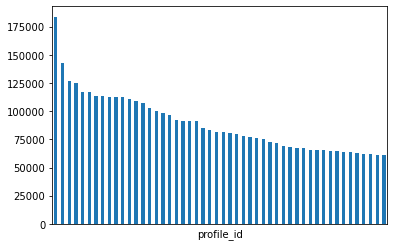

In [13]:
# RQ2_1_2.plot(x="profile_id", y="n_posts", kind="bar", xticks=[], legend=False)

--- EXPLORATORY DATA ANALYSIS (EDA) ---

In [46]:
### Locations dataset ###
#print(df_loc.shape)
#print(df_loc.isna().sum())

### Posts dataset ###
#print(df_posts.shape)
#print(df_posts.isna().sum())

### Profiles dataset ###
# print(df_prof.shape)
#print(df_prof.isna().sum())
# print(df_prof["followers"].max())
# print(df_prof["followers"].mean())

(4509586, 11)
285457645.0
4739.899180397426


In [ ]:
# RQ2_2
# RQ2_2 = df_posts[["post_id", "numbr_likes"]].copy()